In [1]:
%matplotlib inline

import pandas as pd
import intake
catalog = intake.cat.access_nri
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import pandas as pd
import IPython.display
import cmocean as cm

from dask.distributed import Client


import sys, os

os.chdir(os.path.join(os.getcwd(), "ACCESS-OM2-updated/figures/equatorial_pacific"))
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata

print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
#cc.start_cluster()
client = Client("tcp://10.6.43.39:8786")
client

<Client: 'tcp://10.6.122.47:8786' processes=1 threads=28, memory=126.00 GiB>

In [5]:
def find_temp(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    
    cat_subset = catalog[expt]
    var_search = cat_subset.search(variable='temp', frequency='1 monthly')
    darray = var_search.to_dask()
    darray = darray['temp']
    if offset:
        td = pd.Timedelta(days=offset)
        darray = darray.assign_coords(time=darray.time + td)
    temp = darray
    upper_temp_eq = temp.sel(st_ocean=slice(0,300)).sel(yt_ocean=0., method='nearest')\
                        .sel(xt_ocean=slice(-217,-95)).sel(time=slice(pd.Timestamp(1998,1,1),None))\
                        .mean('time').load() - 273.15
    upper_temp_140w = temp.sel(st_ocean=slice(0,300)).sel(yt_ocean=slice(-8,10))\
                        .sel(xt_ocean=-140.,method='nearest').sel(time=slice(pd.Timestamp(1998,1,1),None))\
                        .mean('time').load() - 273.15

    return upper_temp_eq, upper_temp_140w


def find_u(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    
    cat_subset = catalog[expt]
    var_search = cat_subset.search(variable='u', frequency='1 monthly')
    darray = var_search.to_dask()
    darray = darray['u']
    if offset:
        td = pd.Timedelta(days=offset)
        darray = darray.assign_coords(time=darray.time + td)
    u = darray
    upper_u_eq = u.sel(st_ocean=slice(0,300)).sel(yu_ocean=0., method='nearest')\
                        .sel(xu_ocean=slice(-217,-95)).sel(time=slice(pd.Timestamp(1998,1,1),None))\
                        .mean('time').load()*100
    upper_u_140w = u.sel(st_ocean=slice(0,300)).sel(yu_ocean=slice(-8,10))\
                        .sel(xu_ocean=-140.,method='nearest').sel(time=slice(pd.Timestamp(1998,1,1),None))\
                        .mean('time').load()*100

    return upper_u_eq, upper_u_140w


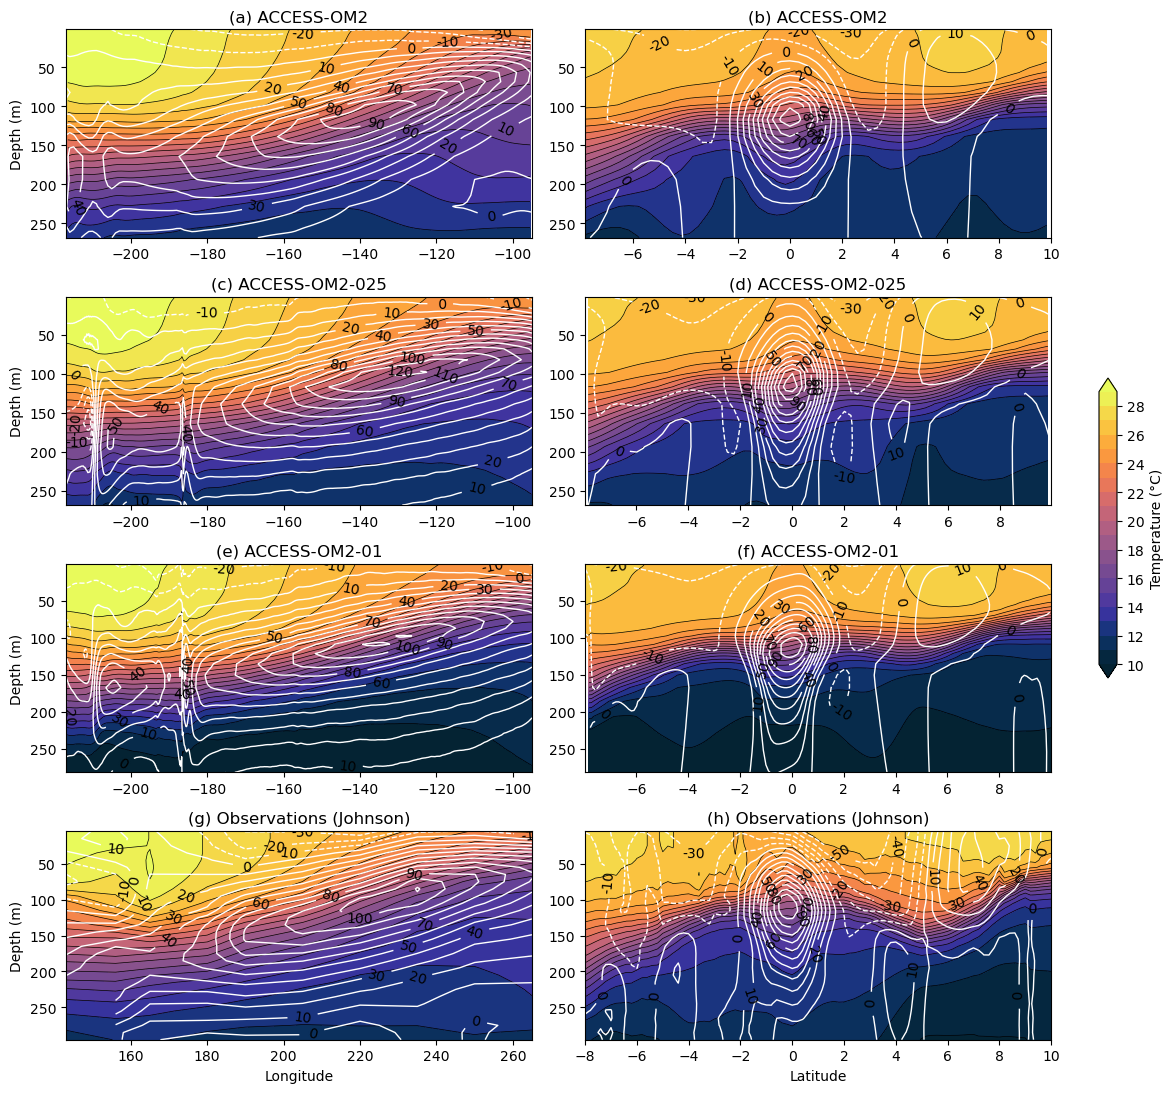

In [7]:
clevelsT = np.arange(10.,30.,1.)
clevelsU = np.arange(-50,130,10)

labels=['(a) ', '(b) ', '(c) ', '(d) ', '(e) ', '(f) ']

fig = plt.figure(figsize=(12,12))
for i, ekey in enumerate(exptdata.exptdict.keys()):
    upper_temp_eq, upper_temp_140w = find_temp(ekey)
    upper_u_eq, upper_u_140w = find_u(ekey)

    plt.subplot(4,2,2*i+1)
    p1=upper_temp_eq.plot.contourf(cmap=cm.cm.thermal, 
                                   levels=clevelsT,
                                   add_colorbar=False, extend='both')
    upper_temp_eq.plot.contour(colors='k', levels=clevelsT,
                                   add_colorbar=False,linewidths=0.5)
#    p2=upper_u_eq.plot.contour(colors='w',levels=clevelsU,linewidths=1)
    xv, yv = np.meshgrid(upper_u_eq.xu_ocean,upper_u_eq.st_ocean)
    p2=plt.contour(xv,yv,upper_u_eq,colors='w',levels=clevelsU,linewidths=1)
    plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('')
    plt.ylabel('Depth (m)')
    plt.title(labels[2*i] + exptdata.exptdict[ekey]['desc'])


    plt.subplot(4,2,2*(i+1))
    p3=upper_temp_140w.plot.contourf(cmap=cm.cm.thermal, 
                                     levels=clevelsT,
                                     add_colorbar=False, extend='both')
    upper_temp_140w.plot.contour(colors='k', levels=clevelsT,
                                     add_colorbar=False,linewidths=0.5)
#    p4=upper_u_140w.plot.contour(colors='w',levels=clevelsU,linewidths=1)
    xv, yv = np.meshgrid(upper_u_140w.yu_ocean,upper_u_140w.st_ocean)
    p4=plt.contour(xv,yv,upper_u_140w,colors='w',levels=clevelsU,linewidths=1)
    plt.clabel(p4, fmt='%2.0f', colors='black', fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('')
    plt.ylabel('')
    plt.title(labels[2*i+1] + exptdata.exptdict[ekey]['desc'])

obs_file = xr.open_dataset('/g/data/v45/fw4078/obs-data/meanfit_m.cdf')
obs_temp = obs_file['POTEMPM']
obs_temp_eq = obs_temp.sel(ZDEP1_50=slice(0,300)).sel(YLAT11_101=0., method='nearest')
obs_temp_140w = obs_temp.sel(ZDEP1_50=slice(0,300)).sel(XLON=220, method='nearest')
lat_obs = obs_temp_140w.YLAT11_101
lon_obs = obs_temp_eq.XLON
dep_obs = obs_temp_eq.ZDEP1_50

obs_u = obs_file['UM']
obs_u_140w = obs_u.sel(ZDEP1_50=slice(0,300)).sel(XLON=220., method='nearest')
lat_u_obs = obs_u_140w.YLAT11_101
obs_u_eq = obs_u.sel(ZDEP1_50=slice(0,300)).sel(YLAT11_101=0., method='nearest')
lon_u_obs = obs_u_eq.XLON

plt.subplot(4,2,7)
p1 = plt.contourf(lon_obs, dep_obs, obs_temp_eq, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lon_obs, dep_obs, obs_temp_eq, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lon_u_obs, dep_obs, obs_u_eq*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Longitude')
plt.ylabel('Depth (m)')
plt.title('(g) Observations (Johnson)')


plt.subplot(4,2,8)
p1 = plt.contourf(lat_obs, dep_obs, obs_temp_140w, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lat_obs, dep_obs, obs_temp_140w, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lat_u_obs, dep_obs, obs_u_140w*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('')
plt.title('(h) Observations (Johnson)')

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Temperature (°C)')

fig.tight_layout(rect=[0, 0.03, 0.9, 0.95])
savefigure('equatorial_pacific')